<h1> Amazon Recommender System using GNN

<h2> Imports

In [1]:
%pip install matplotlib
%pip install torch
%pip install torch-geometric
%pip install scikit-learn
%pip install pandas


import platform
import torch

os_name = platform.system()

if os_name == 'Windows':
    if torch.cuda.is_available():
      %pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
    else:
      %pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
elif os_name == 'Linux':
    if torch.cuda.is_available():
      %pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
    else:
      %pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
else:
    %pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
    
import random
from tqdm.notebook import tqdm
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing
import copy
import gzip
import shutil
import urllib.request
import csv
import json
import os
from datetime import datetime


from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from collections import defaultdict

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj
import torch.nn.functional as F

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Function to build the data
if not os.path.exists("workfiles"):
    os.makedirs("workfiles")
if not os.path.exists("models"):
    os.makedirs("models")
metadata_file = "workfiles/amazon_metadata.csv"
csv_file = "workfiles/amazon_reviews.csv"

def build_work_files(reviews_file_path, meta_file_path):
    user_dict = {}
    product_dict = {}
    next_user_id = 0
    next_product_id = 0

    # Read json file
    meta_dict = {}
    with open(meta_file_path, "r") as input_file:
        for line in input_file:
            try:
                record = json.loads(line)
                meta_dict[record["asin"]] = {"price": record["price"], "name": record["title"]}
            except Exception as e:
                print(line)
    
    with open(metadata_file, "w") as output_file:
        json.dump(meta_dict, output_file, indent=4)    

    print("Metadatos parseados")
    with open(reviews_file_path, "r") as input_file, open(csv_file, "w", newline='') as output_file:
        writer = csv.writer(output_file)

        writer.writerow(["User_id", "User_key", "User_name", "Product_id", "Product_key", "Rate", "Unixtime", "Month"])

        for line in input_file:
            #Reviews
            item = json.loads(line)
            user_id = item.get("reviewerID")
            rewiewer_name = item.get("reviewerName","Unknown")
            product_id = item.get("asin")

            # Assigning a unique number to each user ID
            if user_id not in user_dict:
                user_dict[user_id] = next_user_id
                next_user_id += 1
            user_key = user_dict[user_id]

            # Assigning a unique number to each product ID
            if product_id not in product_dict:
                product_dict[product_id] = next_product_id
                next_product_id += 1
            product_key = product_dict[product_id]

            try:
                rate = float(item["overall"] )
            except Exception as e:
                print(item["overall"])
            unixtime = item["unixReviewTime"]
            month = datetime.utcfromtimestamp(unixtime).month

            writer.writerow([user_id, user_key, rewiewer_name, product_id, product_key, rate, unixtime, month])
            input_file.flush()

    print("Archivo CSV generado exitosamente.")

<h2> Load Dataset

In [3]:
# Avaliable Amazon Datasets for training
from enum import Enum

class Dataset(Enum):
    BEAUTY = 'All_Beauty.json'                   # 371,345 reviews and 32,992 beauty products 
    GIFT_CARDS = 'Gift_Cards.json'               # 147,194 reviews and 1,548 gift card products
    MAGAZINE = 'Magazine_Subscriptions.json'     # 89,689 reviews and 3,493 subscription products


# Change the used datast here
dataset = Dataset.GIFT_CARDS

# Files .gz URLs
url_reviews = f'https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/{dataset.value}.gz'
url_metadata = f'https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/metaFiles2/meta_{dataset.value}.gz'

# Destination file names after download
reviews_file = f"{dataset.value}.gz"
metadatas_file = f"meta_{dataset.value}.gz"

# File names after decompression
if not os.path.exists("datasets"):
    os.makedirs("datasets")

reviews_file_uncompressed = f"datasets/{dataset.value}"
metadata_file_uncompressed = f"datasets/meta_{dataset.value}"

# Download the .gz reviews file
if not os.path.exists(reviews_file_uncompressed):
    urllib.request.urlretrieve(url_reviews, reviews_file)
    # Descomprimir el archivo de reseñas .gz
    with gzip.open(reviews_file, 'rb') as file_gz, open(reviews_file_uncompressed, 'wb') as file_final:
        shutil.copyfileobj(file_gz, file_final)

# Download the .gz metadata file
if not os.path.exists(metadata_file_uncompressed):
    urllib.request.urlretrieve(url_metadata, metadata_file)
    # Decompress the .gz metadata file
    with gzip.open(metadata_file, 'rb') as file_gz, open(metadata_file_uncompressed, 'wb') as file_final:
        shutil.copyfileobj(file_gz, file_final)

print('Descarga y descompresión completadas.')
build_work_files(reviews_file_uncompressed, metadata_file_uncompressed)

_ = os.remove(reviews_file) if os.path.exists(reviews_file) else None
_ = os.remove(metadatas_file) if os.path.exists(metadatas_file) else None

Descarga y descompresión completadas.
Metadatos parseados
Archivo CSV generado exitosamente.


In [4]:
rating_path = "workfiles/amazon_reviews.csv"

rating_df = pd.read_csv(rating_path)

print(rating_df.head())

print(len(rating_df['User_id'].unique()))
print(len(rating_df['Product_id'].unique()))

rating_df.describe()

          User_id  User_key   User_name  Product_id  Product_key  Rate  \
0   APV13CM0919JD         0         LEH  B001GXRQW0            0   1.0   
1  A3G8U1G1V082SN         1        Tali  B001GXRQW0            0   5.0   
2   A11T2Q0EVTUWP         2           Z  B001GXRQW0            0   5.0   
3   A9YKGBH3SV22C         3  Giotravels  B001GXRQW0            0   5.0   
4  A34WZIHVF3OKOL         4    King Dad  B001GXRQW0            0   1.0   

     Unixtime  Month  
0  1229644800     12  
1  1229472000     12  
2  1229472000     12  
3  1229472000     12  
4  1229472000     12  
128877
1548


,User_key,Product_key,Rate,Unixtime,Month
count,147194.000000,147194.000000,147194.000000,1.471940e+05,147194.000000
mean,63182.993410,349.335890,4.671970,1.447245e+09,5.658369
std,36469.790567,269.845055,0.955134,5.221619e+07,3.827231
min,0.000000,0.000000,1.000000,1.228522e+09,1.000000
25%,32362.250000,136.000000,5.000000,1.409789e+09,2.000000
50%,62103.500000,253.000000,5.000000,1.453334e+09,5.000000
75%,94467.750000,519.000000,5.000000,1.485389e+09,9.000000
max,128876.000000,1547.000000,5.000000,1.538266e+09,12.000000


In [5]:
print(rating_df.User_key.max())
print(rating_df.Product_key.max())

128876
1547


In [6]:
rating_df.Rate.value_counts()

Rate
5.0    126689
4.0      8700
1.0      7165
3.0      2996
2.0      1644
Name: count, dtype: int64

In [7]:
# load edges between users and products
def load_edge_csv(df, src_index_col, dst_index_col, link_index_col, rating_threshold=3):
    edge_index = None
    src = [user_id for user_id in  df[src_index_col]]
    
    num_users = len(df[src_index_col].unique())

    dst = [(movie_id) for movie_id in df[dst_index_col]]
    
    link_vals = df[link_index_col].values

    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold

    edge_values = []

    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])
            edge_values.append(link_vals[i])
             
    return edge_index, edge_values

In [8]:
def transform_user(df, user_id):
    user_id = df.loc[df['User_id'] == user_id, 'User_key'].values[0]  # Find the user_id corresponding to the user_key
    return user_id
def transform_prodyct(df, product_key):
    product_id = df.loc[df['Product_key'] == product_key, 'Product_id'].values[0]  # Search for the user_id corresponding to the user_key
    return product_id

print(transform_prodyct(rating_df, 830))

print(transform_user(rating_df, "APV13CM0919JD"))

def load_user_edge(user_id, df):
    user_key = transform_user(df, user_id)
    edge_index = None
    src = []
    dst = []
    link_vals = []

    for i, row in df.iterrows():
        if row['User_key'] == user_key:
            src.append(row['User_key'])
            dst.append(row['Product_key'])
            link_vals.append(row['Rate'])

    edge_attr = torch.tensor(link_vals).view(-1, 1).to(torch.long) >= 1

    edge_values = []

    edge_index = [src, dst]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_values.append(link_vals[i])
    
    return edge_index, edge_values

user_index, user_values = load_user_edge("A20DWM98HQ0LE1", rating_df)
print(user_index)
print(user_values)

B01E4QS95I
0
[[6962], [59]]
[5.0]


In [9]:
# split the edges of the graph using a 80/10/10 train/validation/test split

num_users = len(rating_df['User_key'].unique())
num_products = len(rating_df['Product_key'].unique())
rating_df['keys'] = rating_df['Product_key'] + num_users
print(f"num_users {num_users}, num_products {num_products}")

num_users 128877, num_products 1548


In [10]:
edge_index, edge_values = load_edge_csv(
    rating_df,
    src_index_col='User_key',
    dst_index_col='Product_key',
    link_index_col='Rate',
    rating_threshold=1
)

In [11]:
# Convert to tensor
# We use LongTensor here because the .propagate() method in the model needs either LongTensor or SparseTensor
edge_index = torch.LongTensor(edge_index) 
edge_values = torch.tensor(edge_values)

print(edge_index)
print(edge_index.size())

print(edge_values)
print(edge_values.size())

nodes = edge_index.max().item() + 1

tensor([[     0,      1,      2,  ..., 128874, 128875, 128876],
        [     0,      0,      0,  ...,    858,    858,    858]])
torch.Size([2, 147194])
tensor([1., 5., 5.,  ..., 5., 5., 5.], dtype=torch.float64)
torch.Size([147194])


In [12]:
def convert_r_mat_edge_index_to_adj_mat_edge_index(input_edge_index, input_edge_values):
    R = torch.zeros((num_users, num_products))
    for i in range(len(input_edge_index[0])):
        row_idx = input_edge_index[0][i]
        col_idx = input_edge_index[1][i]
        R[row_idx][col_idx] = input_edge_values[i] # assign actual edge value to Interaction Matrix

    R_transpose = torch.transpose(R, 0, 1)
    
    # create adj_matrix
    adj_mat = torch.zeros((num_users + num_products , num_users + num_products))
    adj_mat[: num_users, num_users :] = R.clone()
    adj_mat[num_users :, : num_users] = R_transpose.clone()
    
    adj_mat_coo = adj_mat.to_sparse_coo()
    adj_mat_coo_indices = adj_mat_coo.indices()
    adj_mat_coo_values = adj_mat_coo.values()
    del adj_mat
    return adj_mat_coo_indices, adj_mat_coo_values


def convert_r_mat_edge_index_to_adj_coo_graph(input_edge_index, input_edge_values):
    # edge_index = torch.tensor(input_edge_index)
    # edge_values = torch.tensor(input_edge_values)
    num_nodes = input_edge_index.max().item() + 1
   
    shape = (num_nodes, num_nodes)

    # Build original sparse matrix
    # input_edge_index[1] += nodes  
    adj_mat_coo = torch.sparse_coo_tensor(input_edge_index, input_edge_values, shape)

    # Calculate transpose sparse matrix
    adj_mat_transpose_coo = torch.sparse_coo_tensor(input_edge_index.flip(0), input_edge_values, shape)

    # Merge sparse matrix
    adj_mat_combined = adj_mat_coo.coalesce() + adj_mat_transpose_coo.coalesce()

    adj_mat_combined_coo = adj_mat_combined.to_sparse_coo()

    return adj_mat_combined_coo.indices(), adj_mat_combined_coo.values()

# import torch_sparse


# def convert_r_mat_edge_index_to_adj_coo_graph(input_edge_index, input_edge_values):
#     num_nodes = input_edge_index.max().item() + 1
#     shape = (num_nodes, num_nodes)

#     # Construir la matriz dispersa original
#     adj_mat_coo = torch.sparse_coo_tensor(input_edge_index, input_edge_values, shape)

#     # Calcular la matriz dispersa transpuesta
#     adj_mat_transpose_coo = torch.sparse_coo_tensor(input_edge_index.flip(0), input_edge_values, shape)

#     # Fusionar las matrices dispersas
#     adj_mat_combined = adj_mat_coo.coalesce() + adj_mat_transpose_coo.coalesce()

#     # Obtener los atributos necesarios para to_scipy()
#     values = adj_mat_combined.values()
#     m, n = adj_mat_combined.shape

#     # Convertir a scipy.sparse.coo_matrix
#     adj_mat_combined_sparse = torch_sparse.to_scipy(adj_mat_combined, values, m, n)

#     # Obtener los índices y valores de la matriz dispersa
#     indices = adj_mat_combined_sparse.indices
#     values = adj_mat_combined_sparse.data

#     return indices, values

    

print(nodes)


128877


In [13]:
def convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index, input_edge_values):
    
    sparse_input_edge_index = SparseTensor(row=input_edge_index[0], 
                                           col=input_edge_index[1], 
                                           value = input_edge_values,
                                           sparse_sizes=((num_users + num_products), num_users + num_products))
    
    adj_mat = sparse_input_edge_index.to_dense()
    interact_mat = adj_mat[: num_users, num_users :]
    
    r_mat_edge_index = interact_mat.to_sparse_coo().indices()
    r_mat_edge_values = interact_mat.to_sparse_coo().values()
    del adj_mat
    
    return r_mat_edge_index, r_mat_edge_values



def inversa(edge_index, edge_values):
    num_nodes = edge_index.max().item() + 1
  
    # Filtrar los índices y valores para obtener las filas y columnas correspondientes a num_users
    filtered_indices = edge_index[:, :num_nodes+1]
 
    filtered_values = edge_values[:num_nodes+1]
    #filtered_indices[1] -= nodes
 
    
    # Crear una nueva matriz dispersa con los índices y valores filtrados
    filtered_sparse_matrix = torch.sparse_coo_tensor(filtered_indices,
                                                     filtered_values, 
                                                     size=(num_nodes, num_nodes))
    
    filtered_sparse_matrix = filtered_sparse_matrix.coalesce()

    indices = filtered_sparse_matrix.indices()
    values = filtered_sparse_matrix.values()
    
    return indices, values


# def inversa(edge_index, edge_values):
#     num_nodes = edge_index.max().item() + 1
  
#     # Filtrar los índices y valores para obtener las filas y columnas correspondientes a num_users
#     filtered_indices = edge_index[:, :num_nodes+1]
 
#     filtered_values = edge_values[:num_nodes+1]
#     filtered_indices[1] -= nodes
 
#     sparse_input_edge_index = SparseTensor(row=filtered_indices, 
#                                            col=edge_index[1], 
#                                            value = filtered_values,
#                                            sparse_sizes=((num_users + num_products), num_users + num_products))
#     # Crear una nueva matriz dispersa con los índices y valores filtrados
#     filtered_sparse_matrix = torch.sparse_coo_tensor(filtered_indices,
#                                                      filtered_values, 
#                                                      size=(num_nodes, num_nodes))
    
#     filtered_sparse_matrix = filtered_sparse_matrix.coalesce()

#     indices = filtered_sparse_matrix.indices()
#     values = filtered_sparse_matrix.values()
    
#     return indices, values



In [14]:
num_interactions = edge_index.shape[1]
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(all_indices, 
                                               test_size=0.2, 
                                               random_state=1)

val_indices, test_indices = train_test_split(test_indices, 
                                             test_size=0.5, 
                                             random_state=1)

In [15]:
train_edge_index = edge_index[:, train_indices]
train_edge_value = edge_values[train_indices]

val_edge_index = edge_index[:, val_indices]
val_edge_value = edge_values[val_indices]

test_edge_index = edge_index[:, test_indices]
test_edge_value = edge_values[test_indices]

In [16]:
print(f"num_users {num_users}, num_products {num_products}, num_interactions {num_interactions}")
print(f"train_edge_index {train_edge_index}")
print((num_users + num_products))
print(torch.unique(train_edge_index[0]).size())
print(torch.unique(train_edge_index[1]).size())

print(test_edge_value)
print(test_edge_value.size())

num_users 128877, num_products 1548, num_interactions 147194
train_edge_index tensor([[ 61484,  79362,  82169,  ...,  48793,   5185, 114809],
        [   216,    356,    414,  ...,    184,     36,    819]])
130425
torch.Size([104928])
torch.Size([1498])
tensor([5., 5., 5.,  ..., 3., 5., 5.], dtype=torch.float64)
torch.Size([14720])


In [17]:
train_edge_index, train_edge_values  = convert_r_mat_edge_index_to_adj_mat_edge_index(train_edge_index, train_edge_value)
val_edge_index, val_edge_values = convert_r_mat_edge_index_to_adj_mat_edge_index(val_edge_index, val_edge_value)
test_edge_index, test_edge_values = convert_r_mat_edge_index_to_adj_mat_edge_index(test_edge_index, test_edge_value)

# train_edge_index, train_edge_values  = convert_r_mat_edge_index_to_adj_coo_graph(train_edge_index, train_edge_value)
# val_edge_index, val_edge_values = convert_r_mat_edge_index_to_adj_coo_graph(val_edge_index, val_edge_value)
# test_edge_index, test_edge_values = convert_r_mat_edge_index_to_adj_coo_graph(test_edge_index, test_edge_value)

print(train_edge_index)
print(train_edge_values)

# for i in range(len(train_edge_indexe[1])):
#     if train_edge_indexe[1][i] != train_edge_index_[1][i]:
#         print("SI")

tensor([[     0,      2,      3,  ..., 130424, 130424, 130424],
        [128877, 128877, 128877,  ..., 128861, 128862, 128863]])
tensor([1., 5., 5.,  ..., 5., 5., 5.])


In [18]:
print(train_edge_index)
print(train_edge_index.size())
print(val_edge_index)
print(val_edge_index.size())
print(test_edge_index)
print(test_edge_index.size())

print(f"\n train_edge_values: \n {train_edge_values} \n {train_edge_values.size()}")
print(f"\n val_edge_values: \n {val_edge_values} \n {val_edge_values.size()}")
print(f"\n test_edge_values: \n {test_edge_values} \n {test_edge_values.size()}")


print(len(train_edge_value))

tensor([[     0,      2,      3,  ..., 130424, 130424, 130424],
        [128877, 128877, 128877,  ..., 128861, 128862, 128863]])
torch.Size([2, 235428])
tensor([[     1,     10,     21,  ..., 130411, 130421, 130421],
        [128877, 128877, 128877,  ..., 128761, 128854, 128855]])
torch.Size([2, 29438])
tensor([[    12,     19,     20,  ..., 130415, 130419, 130422],
        [128877, 128877, 128877,  ..., 128792,  68239, 128859]])
torch.Size([2, 29440])

 train_edge_values: 
 tensor([1., 5., 5.,  ..., 5., 5., 5.]) 
 torch.Size([235428])

 val_edge_values: 
 tensor([5., 5., 5.,  ..., 5., 5., 5.]) 
 torch.Size([29438])

 test_edge_values: 
 tensor([4., 5., 5.,  ..., 5., 5., 5.]) 
 torch.Size([29440])
117755


<h2> Implementing LightGCN

In [19]:
# defines LightGCN model
class LightGCN(MessagePassing):
    """LightGCN Model as proposed in https://arxiv.org/abs/2002.02126
    """

    def __init__(self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=False, dropout_rate=0.1):
        """Initializes LightGCN Model

        Args:
            num_users (int): Number of users
            num_items (int): Number of items
            embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 8.
            K (int, optional): Number of message passing layers. Defaults to 3.
            add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
        """
        super().__init__()
        self.dropout_rate = dropout_rate
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.K = K
        self.add_self_loops = add_self_loops


        # define user and item embedding for direct look up. 
        # embedding dimension: num_user/num_item x embedding_dim
        self.users_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
        
        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0

        
        # "Fills the input Tensor with values drawn from the normal distribution"
        # according to LightGCN paper, this gives better performance
        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)
        
        # create a linear layer (fully connected layer) so we can output a single value (predicted_rating)
        self.out = nn.Linear(embedding_dim + embedding_dim, 1)

    def forward(self, edge_index: Tensor, edge_values: Tensor):
        edge_index_norm = gcn_norm(edge_index=edge_index, 
                                   add_self_loops=self.add_self_loops)

        # concat the user_emb and item_emb as the layer0 embing matrix
        # size will be (n_users + n_items) x emb_vector_len.   e.g: 10334 x 64
        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0

        embs = [emb_0] # save the layer0 emb to the embs list
        
        # emb_k is the emb that we are actually going to push it through the graph layers
        # as described in lightGCN paper formula 7
        emb_k = emb_0 

        # push the embedding of all users and items through the Graph Model K times.
        # K here is the number of layers
        for i in range(self.K):
            emb_k = self.propagate(edge_index=edge_index_norm[0], x=emb_k, norm=edge_index_norm[1])
            embs.append(emb_k)  
            
        # the stacked embs is a list of embedding matrix at each layer
        #    it's of shape n_nodes x (n_layers + 1) x emb_vector_len. 
        #        e.g: torch.Size([10334, 4, 64])
        embs = torch.stack(embs, dim=1)
        
        # From LightGCn paper: "In our experiments, we find that setting α_k uniformly as 1/(K + 1)
        #    leads to good performance in general."
        emb_final = torch.mean(embs, dim=1) # E^K
        
        users_emb_final, items_emb_final = torch.split(emb_final, 
                                                       [self.num_users, self.num_items]) # splits into e_u^K and e_i^K


        r_mat_edge_index, _ = convert_adj_mat_edge_index_to_r_mat_edge_index(edge_index, edge_values)
        # r_mat_edge_index, _ = inversa(edge_index, edge_values)
        
        src, dest =  r_mat_edge_index[0], r_mat_edge_index[1]
        
        # applying embedding lookup to get embeddings for src nodes and dest nodes in the edge list
        user_embeds = users_emb_final[src]
        item_embeds = items_emb_final[dest]
        
        # output dim: edge_index_len x 128 (given 64 is the original emb_vector_len)
        output = torch.cat([user_embeds, item_embeds], dim=1)
        
        # push it through the linear layer
        output = self.out(output)
        
        return output
    
    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

layers = 1 
model = LightGCN(num_users=num_users, 
                 num_items=num_products, 
                 K=layers)

<h2>Training

In [21]:
# define contants
ITERATIONS = 4000
EPOCHS = 10

BATCH_SIZE = 1024

LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 10
LAMBDA = 1e-6


In [22]:
print(f"BATCH_SIZE {BATCH_SIZE}")

BATCH_SIZE 1024


In [23]:
# setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")


model = model.to(device)
model.train()

# add decay to avoid overfit
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.01)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)


loss_func = nn.MSELoss()

Using device cpu.


In [24]:
def get_recall_at_k(input_edge_index, 
                     input_edge_values, # the true label of actual ratings for each user/item interaction
                     pred_ratings, # the list of predicted ratings
                     k=10, 
                     threshold=3.0):
    with torch.no_grad():
        user_item_rating_list = defaultdict(list)

        for i in range(len(input_edge_index[0])):
            src = input_edge_index[0][i].item()
            dest = input_edge_index[1][i].item()
            true_rating = input_edge_values[i].item()
            pred_rating = pred_ratings[i].item()

            user_item_rating_list[src].append((pred_rating, true_rating))

        recalls = dict()
        precisions = dict()

        for user_id, user_ratings in user_item_rating_list.items():
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
            
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            precisions[user_id] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
            recalls[user_id] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

        overall_recall = sum(rec for rec in recalls.values()) / len(recalls)
        overall_precision = sum(prec for prec in precisions.values()) / len(precisions)

        return overall_recall, overall_precision
    

In [25]:
r_mat_train_edge_index, r_mat_train_edge_values = convert_adj_mat_edge_index_to_r_mat_edge_index(train_edge_index, train_edge_values)
r_mat_val_edge_index, r_mat_val_edge_values = convert_adj_mat_edge_index_to_r_mat_edge_index(val_edge_index, val_edge_values)
r_mat_test_edge_index, r_mat_test_edge_values = convert_adj_mat_edge_index_to_r_mat_edge_index(test_edge_index, test_edge_values)
print(nodes)

# r_mat_train_edge_index, r_mat_train_edge_values = inversa(train_edge_index, train_edge_values)
# for t in r_mat_train_edge_index[1]:
#     print(t)

# print(train_edge_index)
# print(train_edge_values)
# print(r_mat_train_edge_index)
# print(r_mat_train_edge_values)
# r_mat_val_edge_index, r_mat_val_edge_values = inversa(val_edge_index, val_edge_values)
# r_mat_test_edge_index, r_mat_test_edge_values = inversa(test_edge_index, test_edge_values)
# print(rating_df.tail()) 

# for i in range(len(r_mat_val_edge_index[1])):
#     C = rating_df.at[i, 'C']
#     r_mat_val_edge_index[1][i] = C
# print(r_mat_train_edge_index)

128877


In [166]:
# training loop
train_losses = []
val_losses = []
val_recall_at_ks = []

start_time = time.time()

for iter in tqdm(range(ITERATIONS)):
    # forward propagation

    # the rating here is based on r_mat
    pred_ratings = model.forward(train_edge_index, train_edge_values) 
    train_loss = loss_func(pred_ratings, r_mat_train_edge_values.view(-1,1))    
    
    # print(pred_ratings)
    # print(r_mat_train_edge_values)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # going over validation set
    if iter % ITERS_PER_EVAL == 0:
        model.eval()

        with torch.no_grad():
            val_pred_ratings = model.forward(val_edge_index, val_edge_values)
            #r_mat_val_edge_values = r_mat_val_edge_values.float()
            val_loss = loss_func(val_pred_ratings, r_mat_val_edge_values.view(-1,1)).sum()
            
            recall_at_k, precision_at_k = get_recall_at_k(r_mat_val_edge_index, r_mat_val_edge_values, val_pred_ratings, k = 20)
    
                
            val_recall_at_ks.append(round(recall_at_k, 5))
            train_losses.append(train_loss.item())
            val_losses.append(val_loss.item())
        
            print(f"[Iteration {iter}/{ITERATIONS}], train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss.item(), 5)},  recall_at_k {round(recall_at_k, 5)}, precision_at_k {round(precision_at_k, 5)}")

        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()
end_time = time.time()
elapsed_time = end_time - start_time
torch.save(model.state_dict(), f"models/model_{dataset.value}_dataset.pth")
print(f"Tiempo transcurrido: {elapsed_time} seconds")

  0%|          | 0/4000 [00:00<?, ?it/s]

[Iteration 0/4000], train_loss: 23.23376, val_loss: 23.21485,  recall_at_k 0.0, precision_at_k 0.0
[Iteration 200/4000], train_loss: 6.041, val_loss: 11.82367,  recall_at_k 0.0, precision_at_k 0.0
[Iteration 400/4000], train_loss: 3.54698, val_loss: 7.75514,  recall_at_k 0.00088, precision_at_k 0.0018
[Iteration 600/4000], train_loss: 2.70784, val_loss: 6.51822,  recall_at_k 0.01874, precision_at_k 0.02196
[Iteration 800/4000], train_loss: 2.26406, val_loss: 5.92474,  recall_at_k 0.02975, precision_at_k 0.03367
[Iteration 1000/4000], train_loss: 1.98817, val_loss: 5.54941,  recall_at_k 0.04291, precision_at_k 0.0469
[Iteration 1200/4000], train_loss: 1.80125, val_loss: 5.27485,  recall_at_k 0.05634, precision_at_k 0.06065
[Iteration 1400/4000], train_loss: 1.66742, val_loss: 5.05787,  recall_at_k 0.08054, precision_at_k 0.08469
[Iteration 1600/4000], train_loss: 1.56743, val_loss: 4.87882,  recall_at_k 0.1018, precision_at_k 0.10596
[Iteration 1800/4000], train_loss: 1.49038, val_loss:

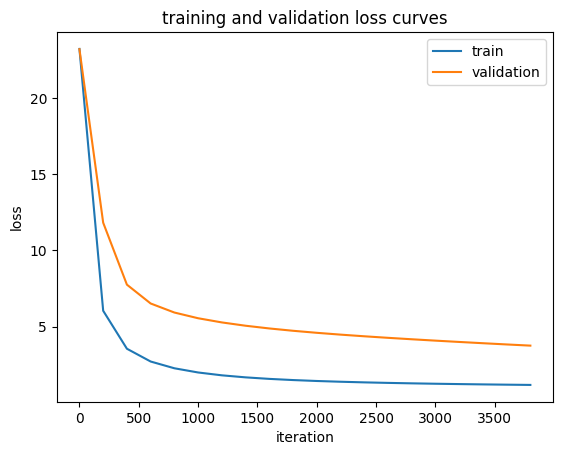

In [167]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

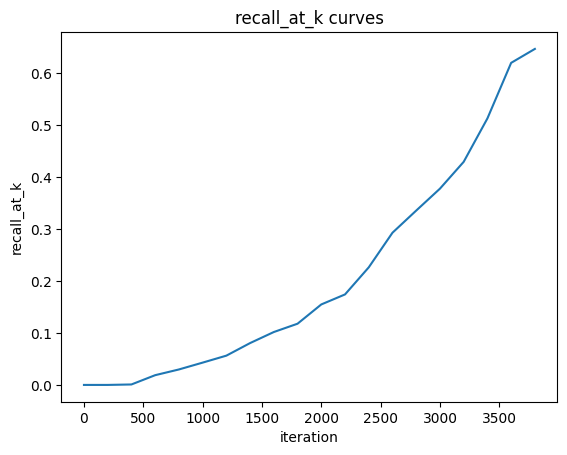

In [168]:
f2 = plt.figure()
plt.plot(iters, val_recall_at_ks, label='recall_at_k')
plt.xlabel('iteration')
plt.ylabel('recall_at_k')
plt.title('recall_at_k curves')
plt.show()

In [169]:
model.eval()
with torch.no_grad():
    pred_ratings = model.forward(test_edge_index, test_edge_values)
    recall_at_k, precision_at_k = get_recall_at_k(r_mat_test_edge_index, 
                                                  r_mat_test_edge_values, 
                                                  pred_ratings, 20)
    print(f"recall_at_k {round(recall_at_k, 5)}, precision_at_k {round(precision_at_k, 5)}")

recall_at_k 0.65969, precision_at_k 0.66205


<h2> Loading Trained Models

In [29]:
# We load one of the pre-trained models and obtain its metrics
load_path = "models/model_cards_dataset.pth"
loaded_dict = torch.load(load_path)

loaded_model = LightGCN(num_users=num_users, 
                 num_items=num_products, 
                 K=layers)

loaded_model.users_emb.weight = nn.Parameter(loaded_dict['users_emb.weight'])
loaded_model.items_emb.weight = nn.Parameter(loaded_dict['items_emb.weight'])
loaded_model.out.weight = nn.Parameter(loaded_dict['out.weight'])
loaded_model.out.bias = nn.Parameter(loaded_dict['out.bias'])

# Model evaluation
loaded_model.eval()
with torch.no_grad():
    pred_ratings = loaded_model.forward(test_edge_index, test_edge_values)
    recall_at_k, precision_at_k = get_recall_at_k(r_mat_test_edge_index, 
                                                  r_mat_test_edge_values, 
                                                  pred_ratings, 20)
    print(f"Final Precision: {round(precision_at_k, 5)}")
    print(f"Final Recall: {round(recall_at_k, 5)}")

Final Precision: 0.75951
Final Recall: 0.75754


In [ ]:
# This is a cell for testing purposes

def load_user_edge(user_id, df):
    user_key = transform_user(df, user_id)
    src = []
    dst = []
    link_vals = []

    for i, row in df.iterrows():
        if row['User_key'] == user_key:
            src.append(row['User_key'])
            dst.append(row['Product_key'])
            link_vals.append(row['Rate'])

    edge_attr = torch.tensor(link_vals).view(-1, 1).to(torch.long) >= 1

    edge_index = torch.tensor([src, dst], dtype=torch.long)

    return edge_index, edge_attr

def user_predictions(user_id, k):
    # index, value = load_user_edge(user_id, rating_df)
    # edge_index = torch.tensor(index).to(device)
    # edge_values = torch.tensor(value).to(device)
    
    loaded_model.eval()
    with torch.no_grad():
        a, b = load_user_edge(user_id, rating_df)
        user_key = transform_user(rating_df, user_id)
        print(user_key)
        # Get the rating predictions for the user
        pred_ratings = loaded_model.forward(train_edge_index, train_edge_values)
        for i in range(len(pred_ratings)):
            if edge_index[0][i] == user_key:
                print(f"({edge_index[0][i]}, {edge_index[1][i]}) = {pred_ratings[i]}")
    
    # Ordena las predicciones de valoración en orden descendente
    #sorted_ratings, sorted_indices = torch.sort(pred_ratings, descending=True)
        #print(pred_ratings)
    # Obtén las primeras K recomendaciones
    # k_recommendations = sorted_indices[:k]
    
    # # Imprime las K recomendaciones
    # print(f"Las primeras {k} recomendaciones para el usuario {user_id} son:")
    # for recommendation in k_recommendations:
    #     print(recommendation)

        
user_predictions("A20DWM98HQ0LE1", 10)

6962


IndexError: index 1548 is out of bounds for dimension 0 with size 1548

In [ ]:

def obtener_recomendaciones_lightgcn(model, user_id, top_k=10):
    # Obtener los índices de los usuarios y elementos correspondientes
    model.eval()
    
    user_index = torch.tensor([user_id], dtype=torch.long)
    item_indices = torch.arange(model.num_users, model.num_users + model.num_items, dtype=torch.long)
    print(user_index)
    print("---------------------------------------")
    print(item_indices)
    print("---------------------------------------")
    # Crear los índices de borde para la interacción entre el usuario y los elementos
    edge_index = torch.stack([user_index.repeat(item_indices.size(0)), item_indices], dim=0)
    print(edge_index)
    # Crear los valores de borde para la interacción entre el usuario y los elementos (todos 1 en este caso)
    edge_values = torch.ones(item_indices.size(0))

    # Obtener las puntuaciones de recomendación utilizando el modelo LightGCN
    with torch.no_grad():
        recommendation_scores = model.forward(edge_index, edge_values)
    
    max_value, max_index = torch.max(recommendation_scores, dim=0)
    print(max_index)
    print(max_value)

    for i in range(len(recommendation_scores)):
        print(f"Indice = {i}    valor = {recommendation_scores[i]}")

    # Ordenar las puntuaciones en orden descendente y obtener los índices de los productos recomendados
    top_scores, top_indices = torch.topk(recommendation_scores.squeeze(), k=top_k)

    print("---------------------------")
    print(top_scores)

    # Obtener los productos recomendados utilizando los índices
    recommended_products = top_indices.tolist()
    print("---------------------------AQUI")
    for i in top_indices:
        print(item_indices[i])

    return recommended_products

obtener_recomendaciones_lightgcn(loaded_model, 0, 10)


tensor([0])
---------------------------------------
tensor([128877, 128878, 128879,  ..., 130422, 130423, 130424])
---------------------------------------
tensor([[     0,      0,      0,  ...,      0,      0,      0],
        [128877, 128878, 128879,  ..., 130422, 130423, 130424]])
tensor([830])
tensor([3.1125])
Indice = 0    valor = tensor([2.6945])
Indice = 1    valor = tensor([2.7376])
Indice = 2    valor = tensor([1.3688])
Indice = 3    valor = tensor([1.9743])
Indice = 4    valor = tensor([2.2773])
Indice = 5    valor = tensor([1.9010])
Indice = 6    valor = tensor([1.9788])
Indice = 7    valor = tensor([2.6630])
Indice = 8    valor = tensor([2.4917])
Indice = 9    valor = tensor([2.8652])
Indice = 10    valor = tensor([2.6401])
Indice = 11    valor = tensor([2.1706])
Indice = 12    valor = tensor([2.5179])
Indice = 13    valor = tensor([2.4420])
Indice = 14    valor = tensor([2.0548])
Indice = 15    valor = tensor([2.4388])
Indice = 16    valor = tensor([2.6230])
Indice = 17    

[830, 829, 324, 186, 455, 184, 35, 58, 97, 118]

In [175]:
# user_id = 1000  # ID del usuario para el cual deseas obtener las recomendaciones
# top_k = 11  # Número de elementos recomendados que deseas obtener

# # Obtener los índices de los usuarios y elementos correspondientes
# user_index = torch.tensor([user_id], dtype=torch.long)
# item_indices = torch.arange(model.num_users, model.num_users + model.num_items, dtype=torch.long)

# # Crear los índices de borde para la interacción entre el usuario y los elementos
# edge_index = torch.stack([user_index.repeat(item_indices.size(0)), item_indices], dim=0)

# # Crear los valores de borde para la interacción entre el usuario y los elementos (todos 1 en este caso)
# edge_values = torch.ones(item_indices.size(0))

# # Obtener las puntuaciones de recomendación utilizando el modelo LightGCN
# recommendation_scores = model.forward(edge_index, edge_values)

# # Obtener los k elementos recomendados
# top_scores, top_indices = torch.topk(recommendation_scores.squeeze(), k=top_k)

# # Obtener los índices de los elementos recomendados
# recommended_indices = top_indices.tolist()

# # Imprime los productos recomendados
# print(recommended_indices)



def obtener_recomendaciones_lightgcn(model, user_id, top_k=10):
    model.eval()
    # Obtener el índice del usuario
    user_index = torch.tensor([user_id], dtype=torch.long)

    # Obtener los índices de los elementos correspondientes
    item_indices = torch.arange(model.num_users, model.num_users + model.num_items, dtype=torch.long)

    # Crear los índices de borde para la interacción entre el usuario y los elementos
    edge_index = torch.cat([user_index.repeat(item_indices.size(0)).unsqueeze(0), item_indices.unsqueeze(0)], dim=0)

    # Crear los valores de borde para la interacción entre el usuario y los elementos (todos 1 en este caso)
    edge_values = torch.ones(item_indices.size(0))

    # Obtener las puntuaciones de recomendación utilizando el modelo LightGCN
    with torch.no_grad():
        recommendation_scores = model.forward(edge_index, edge_values)

    # Ordenar las puntuaciones en orden descendente y obtener los índices de los productos recomendados
    top_scores, top_indices = torch.topk(recommendation_scores.squeeze(), k=top_k)
    # print(top_scores)
    # print(top_indices)
    # Obtener los productos recomendados utilizando los índices
    recommended_products = top_indices.tolist()

    return recommended_products

def user_predictions(model, user_id, k = 10):
    user_name = transform_user(rating_df, user_id)
    recommendations = obtener_recomendaciones_lightgcn(model, 2, k)
    metadata = pd.read_json("workfiles/amazon_metadata.csv")
    iter = 1
    print(f"Recomendations for user {user_id}: (ordered by preference): ")
    for r in recommendations:
        p = transform_prodyct(rating_df, r)
        price = metadata[p].get("price", "Unknown")
        print(f"Product {iter} = Name: {metadata[p]['name']}   price: {price}")
        iter += 1

user_predictions(model, 'A5QQOOZJOVPSF')


Recomendations for user A5QQOOZJOVPSF: (ordered by preference): 
Product 1 = Name: Amazon.com Gift Card in a Holiday Sprig Box   price: 
Product 2 = Name: Amazon.com Gift Card in a Santa Smile Tin   price: $25.00
Product 3 = Name:  Amazon Gift Card - Print - Happy Birthday (Balloons)   price: 
Product 4 = Name:  Amazon eGift Card - Thank You (Smile)   price: 
Product 5 = Name: Amazon.com Gift Card in a Kraft Paper Reveal with Jingle Bells   price: $20.00
Product 6 = Name: Amazon.com Gift Card in a Polka Dot Reveal (Classic Black Card Design)   price: $15.00
Product 7 = Name:  Amazon eGift Card - Birthday (Make a Wish)   price: 
Product 8 = Name: Amazon.com Gift Card with a Holiday Teddy Bear - Limited Edition   price: 
Product 9 = Name:  Amazon eGift Card - Happy Birthday (Balloons)   price: 
Product 10 = Name:  Amazon eGift Card - Amazon Boxes   price: 
